In [174]:
%matplotlib inline

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
import re

import pandas as pd

import lstm_model
import utils
import benchmarkfunctions

In [2]:
# read files from dirs
BASE_DIR = './spearmint-config'

In [3]:
def parse_run_log(path, xcols, run_id="something" ):
    with open(path) as f:
        data = []
        for l in f.readlines():
            output = float(re.findall(r"y=(.+)", l)[0])
            job_id = int(re.findall(r"job #\s*(\d+)", l)[0])
            xs = map( lambda x : float(x), re.findall(r"\((.+)\)", l)[0].split(',') )
            data.append((run_id,job_id,output,*xs))
        return pd.DataFrame(data, columns= ['job_id', 'job_run', 'y'] + xcols)
            
parse_run_log( '%s/%s/%s' % (BASE_DIR,'goldstein_price_2d/runs', '1496875564' ), ['x1','x2'], run_id='1496875564')

,job_id,job_run,y,x1,x2
0,1496875564,1,24376.000000,-2.00000,-2.00000
1,1496875564,2,600.000000,0.00000,0.00000
2,1496875564,3,315857.874716,1.99891,-2.00000
3,1496875564,4,608747.095845,-0.83127,2.00000
4,1496875564,5,18975.248260,-2.00000,-1.08106
5,1496875564,6,548310.970656,-1.99854,1.78219
6,1496875564,7,89718.645278,-1.99999,0.41809
7,1496875564,8,2676.903598,2.00000,1.14413
8,1496875564,9,181.142330,2.00000,0.42958
9,1496875564,10,1585.175353,2.00000,0.82465


In [165]:
def retrieve_runs_from_dir(dirname, xcols, runs_dir="runs"):
    dir_path = "%s/%s/%s/"  % ( BASE_DIR, dirname, runs_dir )
    data = []
    for f in listdir(dir_path):
        if not isfile(join(dir_path, f)):
            continue
        
        df = parse_run_log( '%s/%s' % (dir_path, f ), xcols, f)
        
        data.append(df)
    return data

results = retrieve_runs_from_dir('goldstein_price_2d', ['x1','x2'])
SPEARMINT_GOLDSTEIN_RESULTS = results

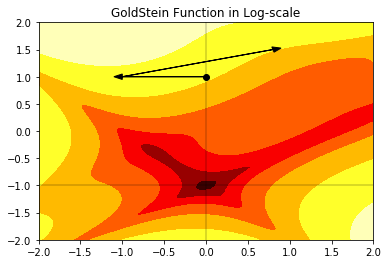

In [5]:
def plotGoldSteinEvaluation(sampling_points, title="GoldStein Function in Log-scale"):
    xx_N = 100
    lin_range = 2
    xx_lin = np.linspace(-lin_range, lin_range, xx_N)
    yy_lin = np.linspace(-lin_range, lin_range, xx_N)
    xx_g, yy_g = np.meshgrid(xx_lin, yy_lin)
    vec_goldstein = np.vectorize(utils.goldstein_price)

    z = np.log(vec_goldstein(xx_g, yy_g))

    plt.contourf(xx_g, yy_g, z, cmap='hot')

    plt.plot([0, 0], [-lin_range, lin_range], 'k-', lw=0.3)
    plt.plot([-lin_range, lin_range], [-1, -1], 'k-', lw=0.3)
    
    if len(sampling_points) > 0:
        plt.scatter(sampling_points[0,0], sampling_points[0,1], color = "k", marker = "o")

        for i in range(1,len(sampling_points)):
            prev = sampling_points[i-1]
            curr = sampling_points[i]
            plt.arrow(prev[0], prev[1], curr[0] - prev[0], curr[1] - prev[1], head_width=0.1, head_length=0.1, fc='k', ec='k')
            
    plt.title(title)
    
sampling_data = np.array([(0,1), (-1,1), (0.8,1.5)])
plotGoldSteinEvaluation(sampling_data)

# Spearmint walks on GoldStein Function

Goldstein Price Optimization from 20 Bayesian Optimization Runs in 10 steps


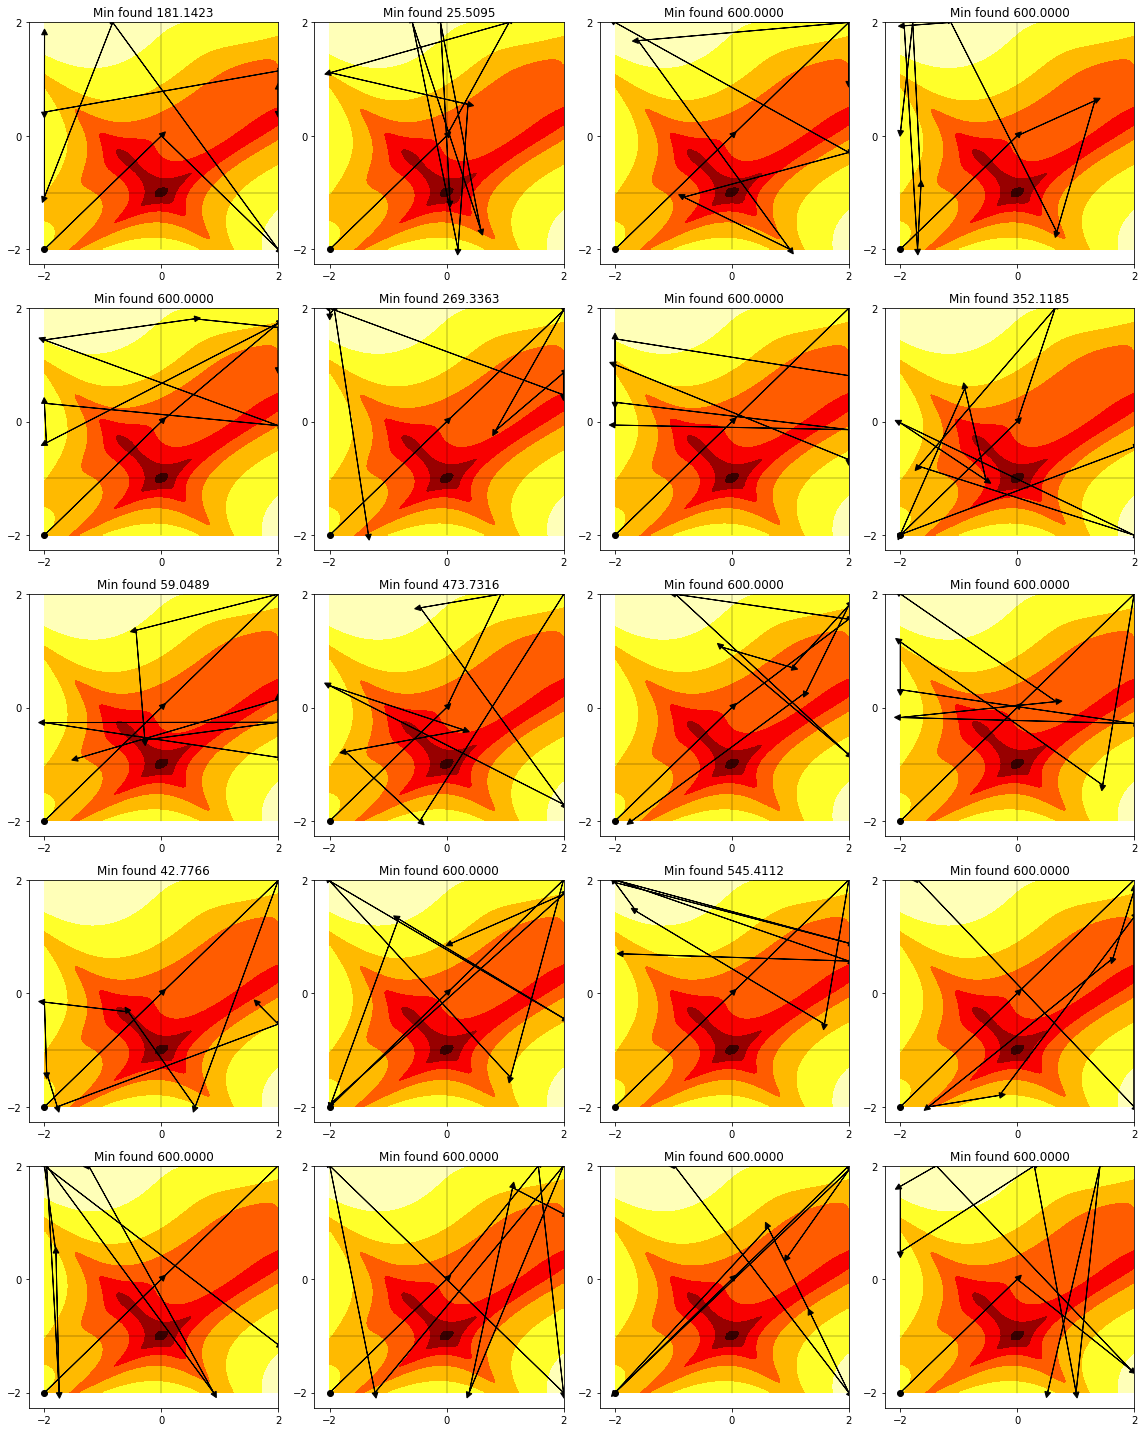

In [6]:
plt.figure(figsize=(16,20))

print('Goldstein Price Optimization from 20 Bayesian Optimization Runs in 10 steps')

for i in range(len(results)):

    df = results[i]
    data = df.as_matrix(columns=['x1','x2'])
    y_min = df.y.min()
    plt.subplot(5,4, i+1)
    title = "Min found %5.4f" % y_min
    plotGoldSteinEvaluation(data,title=title)
    plt.xticks([-2,0,2])
    plt.yticks([-2,0,2])
plt.tight_layout()

# Spearmint on GP functions

In [7]:
x_2d, a_2d, min_2d, max_2d = utils.loadData(2, 'testing')

In [8]:
print(x_2d[0].shape)
print(a_2d.shape)

(6, 2)
(2000, 6, 1)


In [9]:
DIM = 2
N_BUMPS = 6
LENGTH = 2.0/N_BUMPS*np.sqrt(DIM)

def kernel(x1,x2):
    return np.exp(-1.0/LENGTH**2*np.sum((np.expand_dims(x1,axis=2) - np.expand_dims(x2,axis=1))**2, axis = 3))


def GP(X,A,x):
    k_xX = kernel(x,X)
    return np.squeeze(np.matmul(k_xX,  A),axis=(2,))

def normalize(minv, maxv, y):
    return 2*(y-minv)/(maxv-minv)-1.0

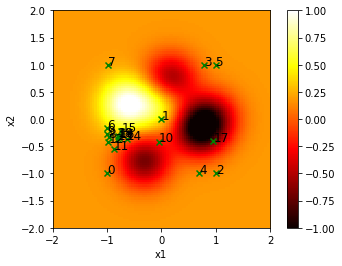

In [12]:
# Read data from config file
X_PLOT_RANGE = 100
X_PLOT_LIMIT = 2

XX1 = np.linspace(-X_PLOT_LIMIT, X_PLOT_LIMIT, X_PLOT_RANGE)
XX2 = np.linspace(-X_PLOT_LIMIT, X_PLOT_LIMIT, X_PLOT_RANGE)
XX = np.array(np.meshgrid(XX1,XX2)).T.reshape(1,-1,2)

def compute_gp_function_values(xx, data_idx=1):
    X = np.expand_dims(x_2d[data_idx], axis=0)
    A = a_2d[data_idx]
    miv = min_2d[data_idx]
    mxv = max_2d[data_idx]

    z = GP(X,A, xx).T
    f_values = normalize(miv, mxv, z)
    

    return f_values

def spearmint_sampling_points(data_idx=1):
    log_name = 'gp-%d' % data_idx
    df = parse_run_log( '%s/%s/%s' % (BASE_DIR,'gp-test/runs', log_name ), ['x1','x2'], run_id=log_name)
    sampling_points = df[['x1','x2']].as_matrix()
    return sampling_points
    
def plot_gp_function(f_values, sampling_points, colorbar=False):
    
    extend = [-X_PLOT_LIMIT,X_PLOT_LIMIT,-X_PLOT_LIMIT,X_PLOT_LIMIT]
    plt.imshow(f_values.reshape(X_PLOT_RANGE,X_PLOT_RANGE), cmap='hot', interpolation='nearest', extent=extend, origin="lower", vmin=-1, vmax=1)
   
    if colorbar:
        plt.colorbar()

    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.scatter(sampling_points[:,0], sampling_points[:,1], color = "green", marker = "x")
    for i in range(len(sampling_points)):
        curr = sampling_points[i]
        plt.text(curr[0], curr[1], str(i), fontsize=12, color="black")
    
data_idx =5
f_values = compute_gp_function_values(XX, data_idx=data_idx)
sm_x_100th = spearmint_sampling_points(data_idx=data_idx)
plot_gp_function(f_values, sm_x_100th, colorbar=True)

In [11]:
sm_x_100th.shape

(20, 2)

In [13]:
compute_gp_function_values(sm_x_100th.reshape(1,-1,2), data_idx=5)

array([[ 0.10244515],
       [ 0.37119904],
       [ 0.23262474],
       [ 0.10050766],
       [ 0.3981329 ],
       [ 0.15555581],
       [-0.43683927],
       [ 0.14097348],
       [-0.53607277],
       [-0.49031689],
       [ 0.64063659],
       [-0.4658824 ],
       [-0.4985446 ],
       [-0.66482742],
       [-0.58366057],
       [-0.62970845],
       [-0.67204664],
       [ 0.13810288],
       [-0.67045846],
       [-0.67214569]])

In [14]:
GP_TEST_INDICES = [100, 5, 90, 71, 2, 999, 33, 400, 500]

" ".join(map(str,GP_TEST_INDICES))

'100 5 90 71 2 999 33 400 500'

In [15]:
conf = utils.loadConfig()
best_model_2d = 'rnn-cell-2d-1497306764'#conf['experiments']['2D']['best_model']
best_model_2d

'rnn-cell-2d-1497306764'

In [360]:
import lstm_model as my_rnn
from prettytable import PrettyTable
import json

def evaluate_gp_ith_with_model(data_index,model,dim, debug=False):    
    x_2d, a_2d, min_2d, max_2d = utils.loadData(dim, 'testing')

    data_Xt = x_2d[data_index]
    data_At  = a_2d[data_index].reshape(1,-1,1)
    data_mint = min_2d[data_index].reshape(-1,1)
    data_maxt = max_2d[data_index].reshape(-1,1)

    res = None

    model_params = my_rnn.load_model_params(model, debug=True)
    
    with tf.Session() as sess:
        params_dict = {
            'n_bumps': model_params['n_bumps'],
            'dim' : model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'forget_bias': model_params['forget_bias'],
            'n_steps': model_params['n_steps'],
            'l': model_params['gp_length'],
            'scope': model_params['scope']
        }
        
        Xt, At, mint, maxt, samples_x, samples_y, x_0 = my_rnn.build_training_graph(**params_dict)
        
        saver = tf.train.Saver()
        saver.restore(sess, model_params['model_path'])

        feed_dict = {
            Xt: data_Xt.reshape(1,-1,dim),
            At: data_At,
            mint: data_mint,
            maxt: data_maxt,
            x_0: np.array([-1,-1]).reshape(1,-1)
        }

        res = sess.run(samples_y, feed_dict=feed_dict)
        x_values = sess.run(samples_x, feed_dict=feed_dict)
    return np.array(res).flatten(), np.array(x_values).flatten().reshape(-1,dim)
lstm_eval_gp_400th, lstm_x_gp_400th = evaluate_gp_ith_with_model(400, "rnn-cell-2d-1497305620", dim=2, debug=True)
lstm_eval_gp_400th

./trained_models/rnn-cell-2d-1497305620
Load rnn-cell-2d-1497305620 model
+---------------------+-----------------------------------------------+
| Parameter           | Value                                         |
+---------------------+-----------------------------------------------+
| dim                 | 2                                             |
| epochs              | 600                                           |
| forget_bias         | 5.0                                           |
| gp_length           | 0.4714045207910317                            |
| learning_rate_final | 0.0001                                        |
| learning_rate_init  | 0.005                                         |
| loss_function       | MIN                                           |
| model_path          | ./trained_models/rnn-cell-2d-1497305620/model |
| n_bumps             | 6                                             |
| n_hidden            | 10                                    

array([ 0.38723552,  0.04638755, -0.1623674 ,  0.17495584, -0.0876959 ,
        0.12818754, -0.11098886, -0.31508344,  0.35151184,  0.38750505,
        0.3875134 ,  0.38751304,  0.38725984,  0.38736451,  0.37894428,
        0.20782542,  0.05403948,  0.22719038,  0.15382981,  0.51383889,
        0.47832501], dtype=float32)

In [21]:
lstm_x_gp_400th

array([[-1.        , -1.        ],
       [-0.38248938,  0.9757694 ],
       [ 0.07387248,  0.25323889],
       [-0.27028027,  0.40500936],
       [ 0.17725657, -0.08328035],
       [-0.06274423,  0.10423708],
       [ 0.53972483, -0.32884827],
       [ 0.9400478 , -0.43831179],
       [ 1.7883327 , -0.60703921],
       [ 2.54426026, -0.36156103],
       [ 2.6679585 ,  0.01405975],
       [ 2.3481276 ,  0.63206732],
       [ 1.34150958,  1.30373251],
       [ 0.80953646,  1.7602706 ],
       [ 0.51513833,  1.48440468],
       [-0.03822456,  1.26366854],
       [-0.40263557,  0.90543747],
       [-0.19440529,  0.16673884],
       [ 0.48313916, -0.4845207 ],
       [ 1.13751268, -1.12252629],
       [ 1.00954258, -1.32152593]], dtype=float32)

Tensor("Tile:0", shape=(?, 2), dtype=float32)
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497306764/model


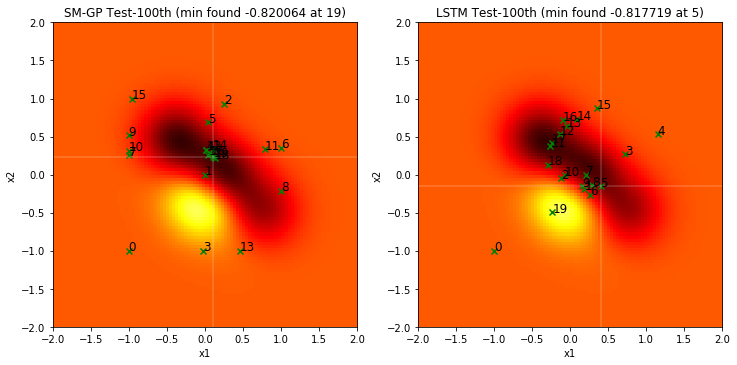

In [22]:
def plot_line_mark(x1,y1):
    plt.plot([x1, x1], [-X_PLOT_LIMIT, X_PLOT_LIMIT], 'w-', lw=0.3)
    plt.plot([-X_PLOT_LIMIT, X_PLOT_LIMIT], [y1,y1] , 'w-', lw=0.3)
    
def plot_comparison2d_on_gp(data_idx):
    plt.figure(figsize=(12,6))
    # for i in range(len(GP_TEST_INDICES)):
    # plot spearmint
    plt.subplot(1,2,1)    
    f_values = compute_gp_function_values(XX, data_idx=data_idx)
    
    sm_x_100th = spearmint_sampling_points(data_idx=data_idx)
    sm_f_values = compute_gp_function_values(sm_x_100th.reshape(1,-1,2), data_idx=data_idx)
    min_sm = np.argmin(sm_f_values)
    plot_gp_function(f_values, sm_x_100th)

    plt.title('SM-GP Test-%dth (min found %f at %d)' % (data_idx, sm_f_values[min_sm], min_sm) )
    plot_line_mark(*sm_x_100th[min_sm, :])
    
    # plot lstm
    plt.subplot(1,2,2)    
    f_values = compute_gp_function_values(XX, data_idx=data_idx)

    lstm_f_values, lstm_x_400 = evaluate_gp_ith_with_model(data_idx, best_model_2d, dim=2)
    
    
    min_lstm = np.argmin(lstm_f_values[:-1])

    plot_gp_function(f_values, lstm_x_400[:-1,:])
    plt.title('LSTM Test-%dth (min found %f at %d)' % (data_idx, lstm_f_values[min_lstm], min_lstm) )
    plot_line_mark(*lstm_x_400[min_lstm, :])
plot_comparison2d_on_gp(GP_TEST_INDICES[0])

In [ ]:
for i in GP_TEST_INDICES:
    plot_comparison2d_on_gp(i)
    plt.savefig('./images-temp/comparision-gp-test-%dth.png' % i)

In [19]:
def evaluate_gp_at_point(data_idx, x1,x2):
    X = np.expand_dims(x_2d[data_idx], axis=0)
    A = a_2d[data_idx]
    miv = min_2d[data_idx]
    mxv = max_2d[data_idx]
    
    xx = np.array([x1,x2]).reshape(1,1,2);

    z = GP(X,A, xx).T
    z_norm = normalize(miv, mxv, z)
    return z_norm
evaluate_gp_at_point(71, -1,-1)

array([[ 0.12905712]])

In [20]:
GP_TEST_INDEX = 400
def plot_gp_min_found():
    evaluation_steps = range(0,20)
    y = np.log(-np.arange(0,5,20))

In [ ]:
parse_run_log( '%s/%s/%s' % (BASE_DIR,'gp-test/runs', 'gp-71' ), ['x1','x2'], run_id='gp-71')

In [226]:
results_gp_400th = retrieve_runs_from_dir('gp-test-ith', ['x1','x2'], runs_dir='runs-400-th')

In [ ]:
len(results_gp_400th)

In [227]:
import unittest
tc = unittest.TestCase('__init__')

def min_up_to_k(data):
    total = len(data)
    mins_up_to_k = [data[0]]
    
    for k in range(1, total):
        m = mins_up_to_k[k-1]
        if mins_up_to_k[k-1] > data[k]:
            m = data[k]
        mins_up_to_k.append(m)
        
    return mins_up_to_k

tc.assertEqual(min_up_to_k([1,3,0.5,2,8,3,4]),[1,1,0.5,0.5,0.5,0.5,0.5])

INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497306764/model


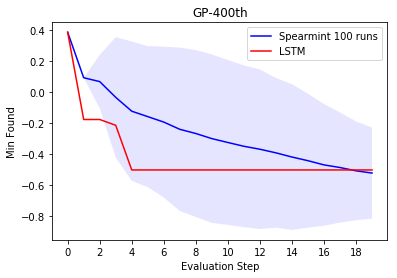

In [228]:
def plot_min_across_runs(data, color="blue") :
    mins_across_runs = []
    total = len(data)
    for  i in range(total):
        df = data[i]
        mins = min_up_to_k(df.y.as_matrix())
        mins_across_runs.append(mins)
        
    # mins_across_runs.shape = run*step
    # aka each step is each column
    mins_across_runs = np.vstack(mins_across_runs)
    
    mean_mins = np.mean(mins_across_runs, axis=0)
    std_mins = np.std(mins_across_runs, axis=0)

    total_means = len(mean_mins)
    x_lins = range(0, total_means)
    plt.plot(x_lins, mean_mins, color = color, label="Spearmint %d runs" % total)
    up = mean_mins + 2*std_mins
    lo = mean_mins - 2*std_mins
    plt.fill_between(x_lins, lo, up, facecolor=color, interpolate=True, alpha=0.1)

    lstm_eval_gp_400th, _ = evaluate_gp_ith_with_model(400, best_model_2d, dim=2)
    lstm_min_at_k = min_up_to_k(lstm_eval_gp_400th[:total_means])
    plt.plot(x_lins, lstm_min_at_k, color = "red", label="LSTM")

    plt.xticks(np.arange(0, len(mean_mins),2))
    plt.xlabel('Evaluation Step')
    plt.ylabel('Min Found')
    plt.legend()

plt.title("GP-400th")
plot_min_across_runs(results_gp_400th)

# LTSM Loss Function Comparison

Tensor("Tile:0", shape=(?, 2), dtype=float32)
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497306764/model
Tensor("Tile:0", shape=(?, 2), dtype=float32)
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497308299/model
Tensor("Tile:0", shape=(?, 2), dtype=float32)
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497313100/model
Tensor("Tile:0", shape=(?, 2), dtype=float32)
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497309842/model
Tensor("Tile:0", shape=(?, 2), dtype=float32)
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497314598/model


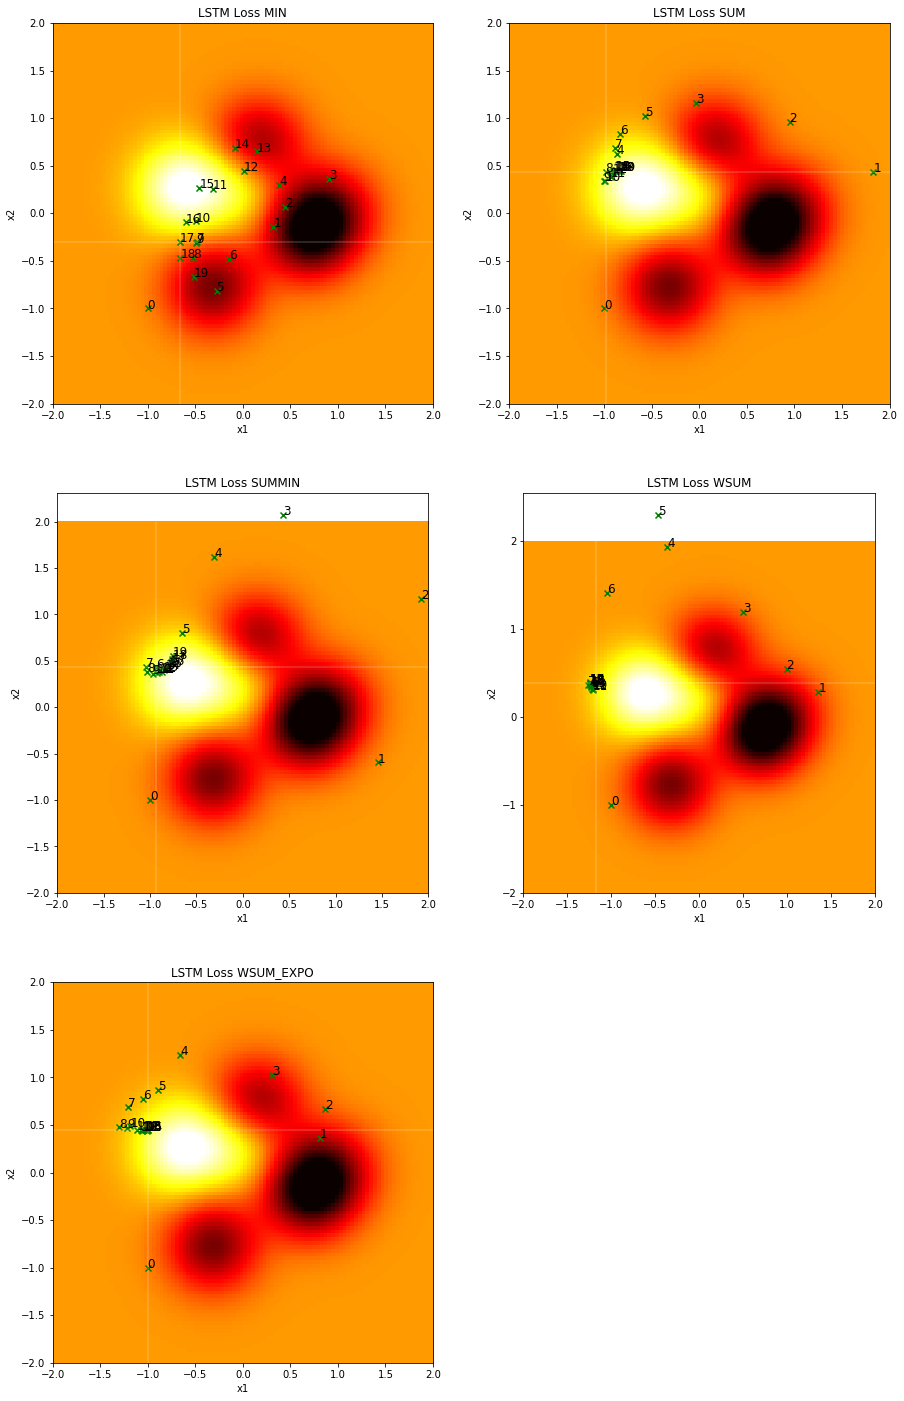

In [23]:
def comparision_of_loss_functions(models, data_index=300):
    f_values = compute_gp_function_values(XX, data_idx=data_idx)
    
    plt.figure(figsize=(15,25))

    keys = list(models.keys())
    keys.sort()
    count = 1
    for k in keys:
        m = models[k]
        lstm_f_values, lstm_x_400 = evaluate_gp_ith_with_model(data_index, m, dim=2)
        min_lstm = np.argmin(lstm_f_values[:-1])
        plt.subplot(3,2,count)
        plot_gp_function(f_values, lstm_x_400[:-1,:])
        plt.title('LSTM Loss %s' % k )
        plot_line_mark(*lstm_x_400[min_lstm, :])
        count = count + 1


models = {
 'MIN': 'rnn-cell-2d-1497306764', # loss : min
 'SUM': 'rnn-cell-2d-1497308299', # loss : sum
 'SUMMIN': 'rnn-cell-2d-1497313100', # loss : summin
 'WSUM': 'rnn-cell-2d-1497309842', # loss : wsum
 'WSUM_EXPO': 'rnn-cell-2d-1497314598' # loss : wsum_expo
}

comparision_of_loss_functions(models)

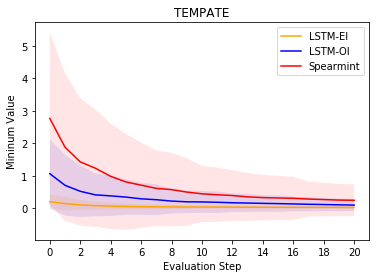

In [237]:
def plot_mins_of_models(data,steps=20,title=""):
    colors = ['Orange', 'Blue', 'red']
    keys = list(data.keys())
    keys.sort()
    x = range(0,steps+1)
    for i in range(len(keys)):
        k = keys[i]
        steps = data[k].shape[1]
        if data[k].shape[0] > 1:
            mms_k = np.apply_along_axis(min_up_to_k, 1, data[k])

            means = np.mean(mms_k, axis=0)
            std = np.std(mms_k, axis=0)

            plt.fill_between(x, means + 2*std, means - 2*std, facecolor=colors[i], alpha=0.1)

            plt.plot(x, means, label=k, c=colors[i])
        else:
            plt.plot(x, min_up_to_k(data[k].reshape(-1,1)), label=k, c=colors[i])

    plt.ylabel("Mininum Value")
    plt.xlabel("Evaluation Step")
    plt.xticks(range(0,steps+1,2))
    plt.title(title)
    plt.legend()

MOCK_DATA = {
    'Spearmint': np.random.rand(100,21)*5,
    'LSTM-EI'  : np.random.rand(100,21)*0.4,
    'LSTM-OI'  : np.random.rand(100,21)*2

}

plot_mins_of_models(MOCK_DATA, title="TEMPATE")

In [362]:
# Get Spearmint Data
# LSTM with different loss 
# pick 2
def compute_y_from_all_testing_data(model, dim, starting_point, debug=False):
    
    x_2d, a_2d, min_2d, max_2d = utils.loadData(dim, 'testing')

    data_Xt = x_2d
    data_At  = a_2d
    data_mint = min_2d.reshape(-1,1)
    data_maxt = max_2d.reshape(-1,1)


    model_params = my_rnn.load_model_params(model, debug=True)

    with tf.Session() as sess:
        params_dict = {
            'n_bumps': model_params['n_bumps'],
            'dim' : model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'forget_bias': model_params['forget_bias'],
            'n_steps': model_params['n_steps'],
            'l': model_params['gp_length'],
            'scope': model_params['scope']
        }

        Xt, At, mint, maxt, samples_x, samples_y, x_0 = my_rnn.build_training_graph(**params_dict)

        saver = tf.train.Saver()
        saver.restore(sess, model_params['model_path'])

        feed_dict = {
            Xt: data_Xt,
            At: data_At,
            mint: data_mint,
            maxt: data_maxt,
            x_0: np.array(starting_point).reshape(1,-1)
        }

        res = sess.run(samples_y, feed_dict=feed_dict)
        # res = 21*2000

        return np.array(res).reshape(21,-1).T
Y_ACROSS_TESTING_LSTM_MIN = compute_y_from_all_testing_data('rnn-cell-2d-1497306764', dim=2, starting_point=[-1,-1])

./trained_models/rnn-cell-2d-1497306764
Load rnn-cell-2d-1497306764 model
+---------------------+-----------------------------------------------+
| Parameter           | Value                                         |
+---------------------+-----------------------------------------------+
| dim                 | 2                                             |
| epochs              | 600                                           |
| forget_bias         | 5.0                                           |
| gp_length           | 0.4714045207910317                            |
| learning_rate_final | 0.0001                                        |
| learning_rate_init  | 0.005                                         |
| loss_function       | MIN                                           |
| model_path          | ./trained_models/rnn-cell-2d-1497306764/model |
| n_bumps             | 6                                             |
| n_hidden            | 100                                   

# Function values average across testing data

Tensor("Tile:0", shape=(?, 2), dtype=float32)
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497306764/model
Tensor("Tile:0", shape=(?, 2), dtype=float32)
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497308299/model


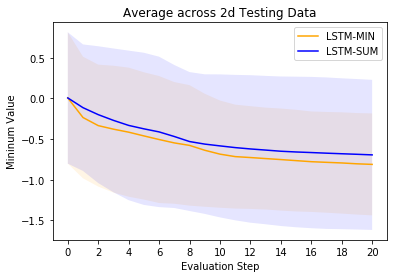

In [167]:
# For 2 data
MINS_OF_MODEL_DATA = {}
SELECTED_MODEL = {
    'LSTM-MIN': 'rnn-cell-2d-1497306764',
    'LSTM-SUM': 'rnn-cell-2d-1497308299' 
}

for k in SELECTED_MODEL.keys():
    MINS_OF_MODEL_DATA[k] = compute_y_from_all_testing_data(SELECTED_MODEL[k], dim=2, starting_point=[-1,-1])

# TODO: Get spearming data 
plot_mins_of_models(MINS_OF_MODEL_DATA, title="Average across 2d Testing Data")

# Function value of 2d benchmark function

In [363]:
def compute_y_of_a_function(model, func, starting_point, debug=False ):
    model_params = my_rnn.load_model_params(model)

    res = None
    with tf.Session() as sess:

        lstm_params = {
            'dim' : model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'forget_bias': model_params['forget_bias'],
            'scope': model_params['scope']
        }
        cell, weights = lstm_model.get_lstm_weights(**lstm_params)
        
        saver = tf.train.Saver()
        saver.restore(sess, model_params['model_path'])

        benchmark_samples_params = {
            'f': func,
            'cell': cell,
            'weights': weights,
            'dim': model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'n_steps': model_params['n_steps'],
            'scope': model_params['scope'],
            'batch_size': 1
        }
        
        samples_benchmark_x, samples_benchmark_y, x_0 = lstm_model.apply_lstm_model(**benchmark_samples_params)
    
        feed_dict = {
            x_0: np.array([-2,-2]).reshape(1,-1)
        }
        sample_y, sample_x = sess.run([samples_benchmark_y, samples_benchmark_x], feed_dict=feed_dict)
        sample_y = np.array(sample_y).reshape(-1,1).T
        sample_x = np.array(sample_x).reshape(-1,1, model_params['dim']).transpose((1,0,2)).reshape(-1,model_params['dim'])
        return sample_y, sample_x
sample_y, sample_x = compute_y_of_a_function('rnn-cell-2d-1497306764', benchmarkfunctions.goldstein_price_tf, starting_point=[-2,-2])

INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497306764/model


INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497306764/model
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497308299/model
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497314598/model


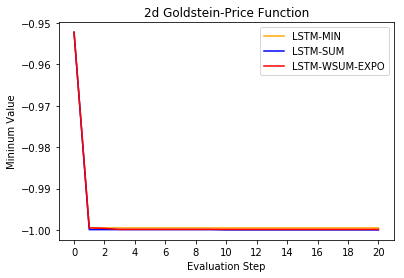

In [364]:
GOLDSTEIN_PRICE_MODEL_DATA = {}
SELECTED_MODEL = {
    'LSTM-MIN': 'rnn-cell-2d-1497306764',
    'LSTM-SUM': 'rnn-cell-2d-1497308299',
    'LSTM-WSUM-EXPO': 'rnn-cell-2d-1497314598'
}

for k in SELECTED_MODEL.keys():
    y, _ = compute_y_of_a_function(SELECTED_MODEL[k], benchmarkfunctions.goldstein_price_tf, starting_point=[-2,-2])
    GOLDSTEIN_PRICE_MODEL_DATA[k] = y

# TODO: Get spearming data 
plot_mins_of_models(GOLDSTEIN_PRICE_MODEL_DATA, title="2d Goldstein-Price Function")

In [365]:
def plot_function_and_sampling_points(func, sampling_points, sampling_y):
    X_PLOT_RANGE = 100
    X_PLOT_LIMIT = 2.5

    XX1 = np.linspace(-X_PLOT_LIMIT, X_PLOT_LIMIT, X_PLOT_RANGE)
    XX2 = np.linspace(-X_PLOT_LIMIT, X_PLOT_LIMIT, X_PLOT_RANGE)
    XX = np.array(np.meshgrid(XX1,XX2)).T.reshape(1,-1,2)    
    
    extend = [-X_PLOT_LIMIT,X_PLOT_LIMIT,-X_PLOT_LIMIT,X_PLOT_LIMIT]
    
    f_values = np.log(func(XX, normalize=False))
    plt.imshow(f_values.reshape(X_PLOT_RANGE,X_PLOT_RANGE).T, cmap='hot', extent=extend, origin="lower")
   
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.scatter(sampling_points[:,0], sampling_points[:,1], color = "green", marker = "x")
    for i in range(len(sampling_points)):
        curr = sampling_points[i]
        plt.text(curr[0], curr[1], str(i), fontsize=12, color="black")
    min_idx = np.argmin(sampling_y)

    plot_line_mark(*sampling_points[min_idx, :])

    
# plot_function_and_sampling_points(benchmarkfunctions.goldstein_price, sample_x, sample_y)

INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497306764/model
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497308299/model
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497314598/model


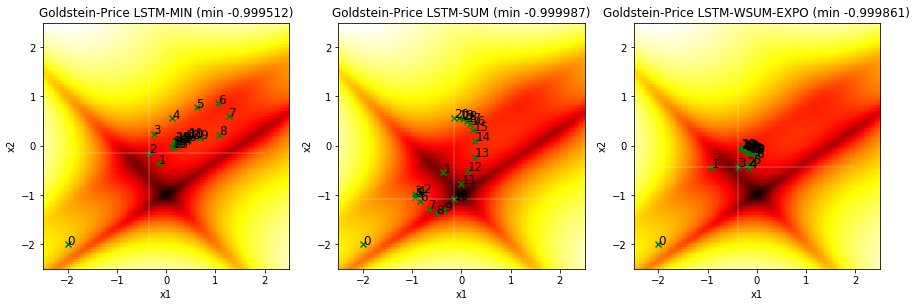

In [366]:
count = 1
plt.figure(figsize=(15,5))
for k in SELECTED_MODEL.keys():
    y, x = compute_y_of_a_function(SELECTED_MODEL[k], benchmarkfunctions.goldstein_price_tf, starting_point=[-2,-2])
    plt.subplot(1,3,count)
    plot_function_and_sampling_points(benchmarkfunctions.goldstein_price, x, y)
    plt.title('Goldstein-Price %s (min %f)' % (k, np.min(y)) )
    count = count + 1

## END

In [357]:
import imp  
imp.reload(lstm_model)  
# imp.reload(benchmarkfunctions)

<module 'lstm_model' from '/Users/heytitle/projects/neural-network-project/lstm_model.py'>

In [312]:
count = 0

In [314]:
count+=1